In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pylab as plt
from tqdm import trange

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from nn import Generator, Discriminator

---

### DATA

In [3]:
n_chan = 1 # Input channels (Binary dataset)
z_dim = 100 # Z latent space dimension
bs = 64

In [4]:
ds = datasets.MNIST(root='./data', download=True, transform=transforms.Compose([
                                                            transforms.Resize(28),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize((0.5,), (0.5,)),
                                                            ]))

dataloader = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=True)

100%|██████████| 9912422/9912422 [00:12<00:00, 786642.16it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42925476.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1174647.96it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7660043.73it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Min: -1.0 Max: 1.0


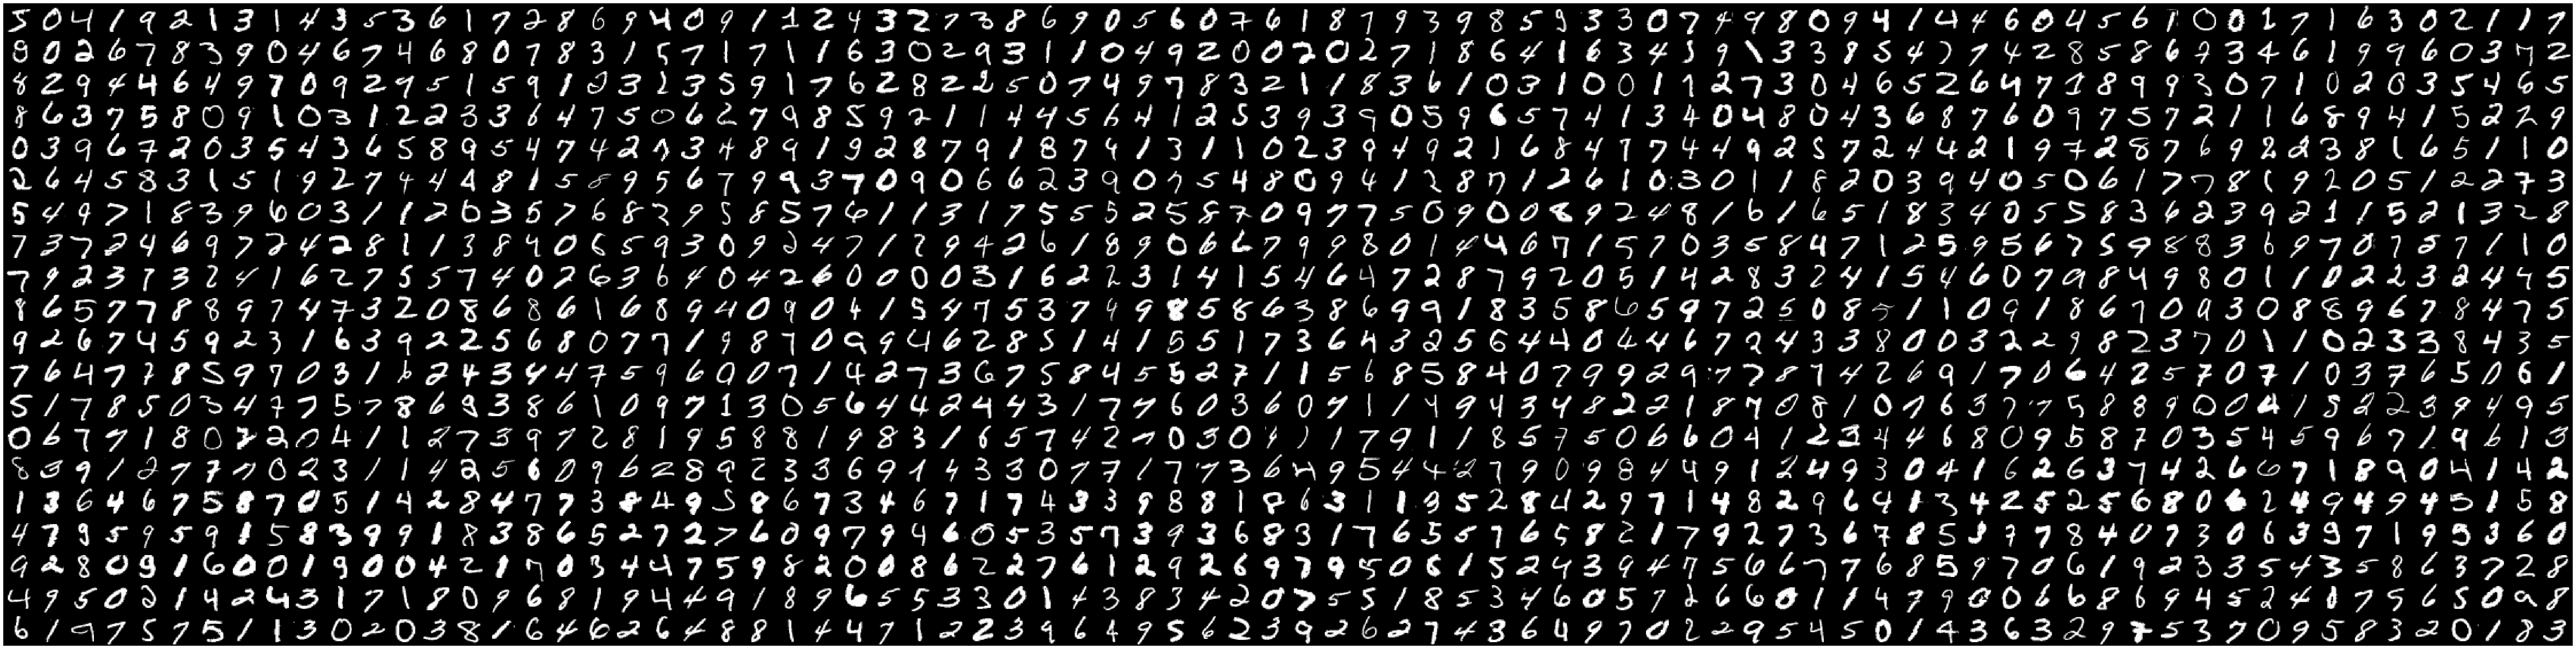

In [5]:
result = np.concatenate([np.concatenate([ds[j][0].permute(1, 2, 0).numpy() for j in range(i*80, (i+1)*80)], axis=1) for i in range(20)], axis=0)

plt.figure(figsize=(80,20))
plt.imshow(result, 'gray')
plt.axis('off'), plt.tight_layout()

print('Min:', result.min(), 'Max:', result.max())

---

### GENERATOR & DISCRIMINATOR

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
netG = Generator()
netG.apply(weights_init)

g_params = netG.parameters()
print("Nparams:", sum(p.nelement() for p in g_params))
print(netG)

Nparams: 3573696
Generator(
  (x_in): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (x_out): Sequential(
    (

In [8]:
netD = Discriminator()
netD.apply(weights_init)

d_params = netD.parameters()
print("Nparams:", sum(p.nelement() for p in d_params))
print(netD)

Nparams: 661248
Discriminator(
  (x_in): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (l1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (l2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (x_out): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Sigmoid()
  )
)


---

### TRAINING

In [9]:
loss_function = nn.BCELoss()

optimD = torch.optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimG = torch.optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [10]:
niter = 3
d_lossi, g_lossi = [], []

for n in (t := trange(niter)):
    for i, data in enumerate(dataloader, 0):
        label = torch.full((data[0].size(0),), 1).float()

        # Discriminator - Real
        netD.zero_grad()
        d_real = netD(data[0])
        lossD_real = loss_function(d_real.squeeze(), label)
        lossD_real.backward()

        # Discriminator - Fake
        noise = torch.randn(data[0].size(0), z_dim, 1, 1)
        g_fake = netG(noise)
        d_fake = netD(g_fake.detach())
        lossD_fake = loss_function(d_fake.squeeze(), label.fill_(0))
        lossD_fake.backward()
        optimD.step()

        lossD = lossD_real + lossD_fake

        # Generator
        netG.zero_grad()
        d_fake = netD(g_fake)
        lossG = loss_function(d_fake.squeeze(), label.fill_(1))
        lossG.backward()
        optimG.step()

        d_lossi.append(lossD.item())
        g_lossi.append(lossG.item())
        t.set_description("Batch (Total: 937): %.0f | Discriminator loss: %.2f | Generator loss: %.2f" % (i, lossD.item(), lossG.item()))

Batch (Total: 937): 937 | Discriminator loss: 0.98 | Generator loss: 1.29: 100%|██████████| 3/3 [29:53<00:00, 597.75s/it]


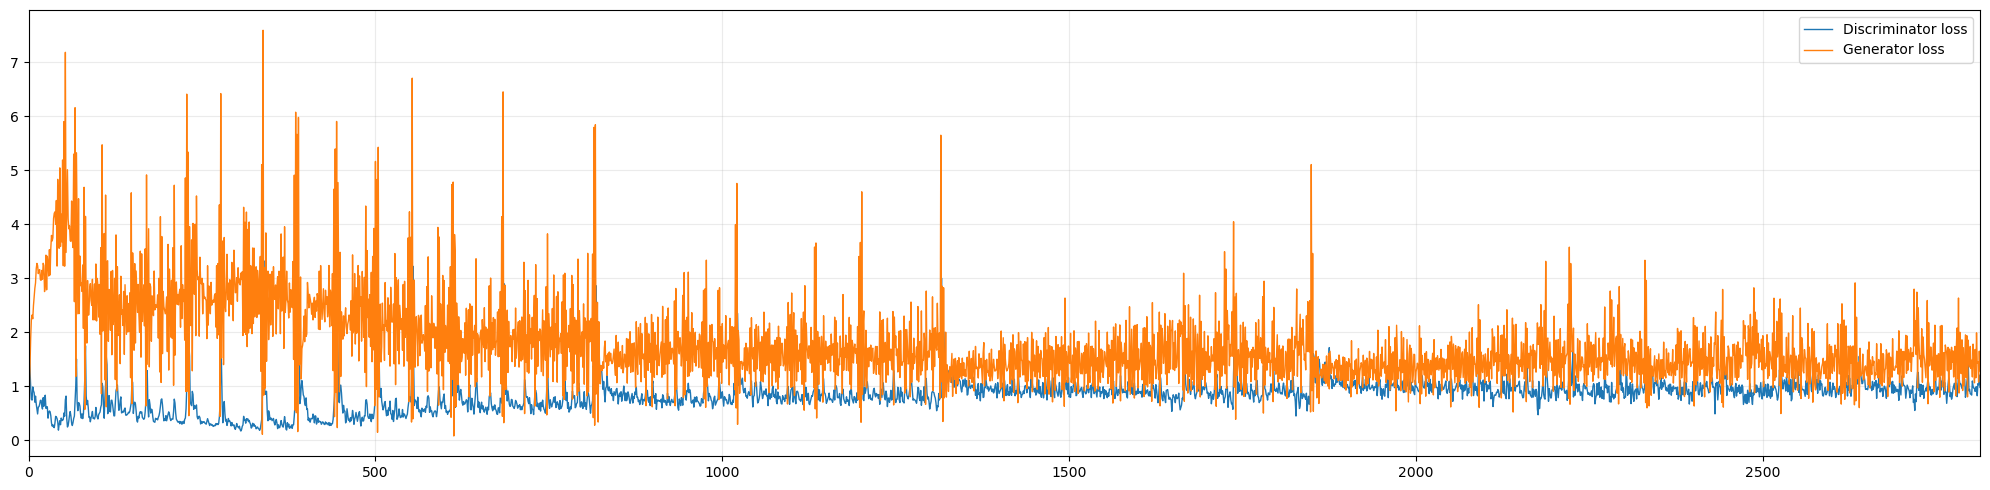

In [11]:
plt.figure(figsize=(20,5))
plt.plot(d_lossi, lw=1, label='Discriminator loss'), plt.plot(g_lossi, lw=1, label='Generator loss')
plt.xlim(0, len(d_lossi)-1)
plt.grid(alpha=0.25), plt.legend()
plt.tight_layout()

---

### INFERENCE

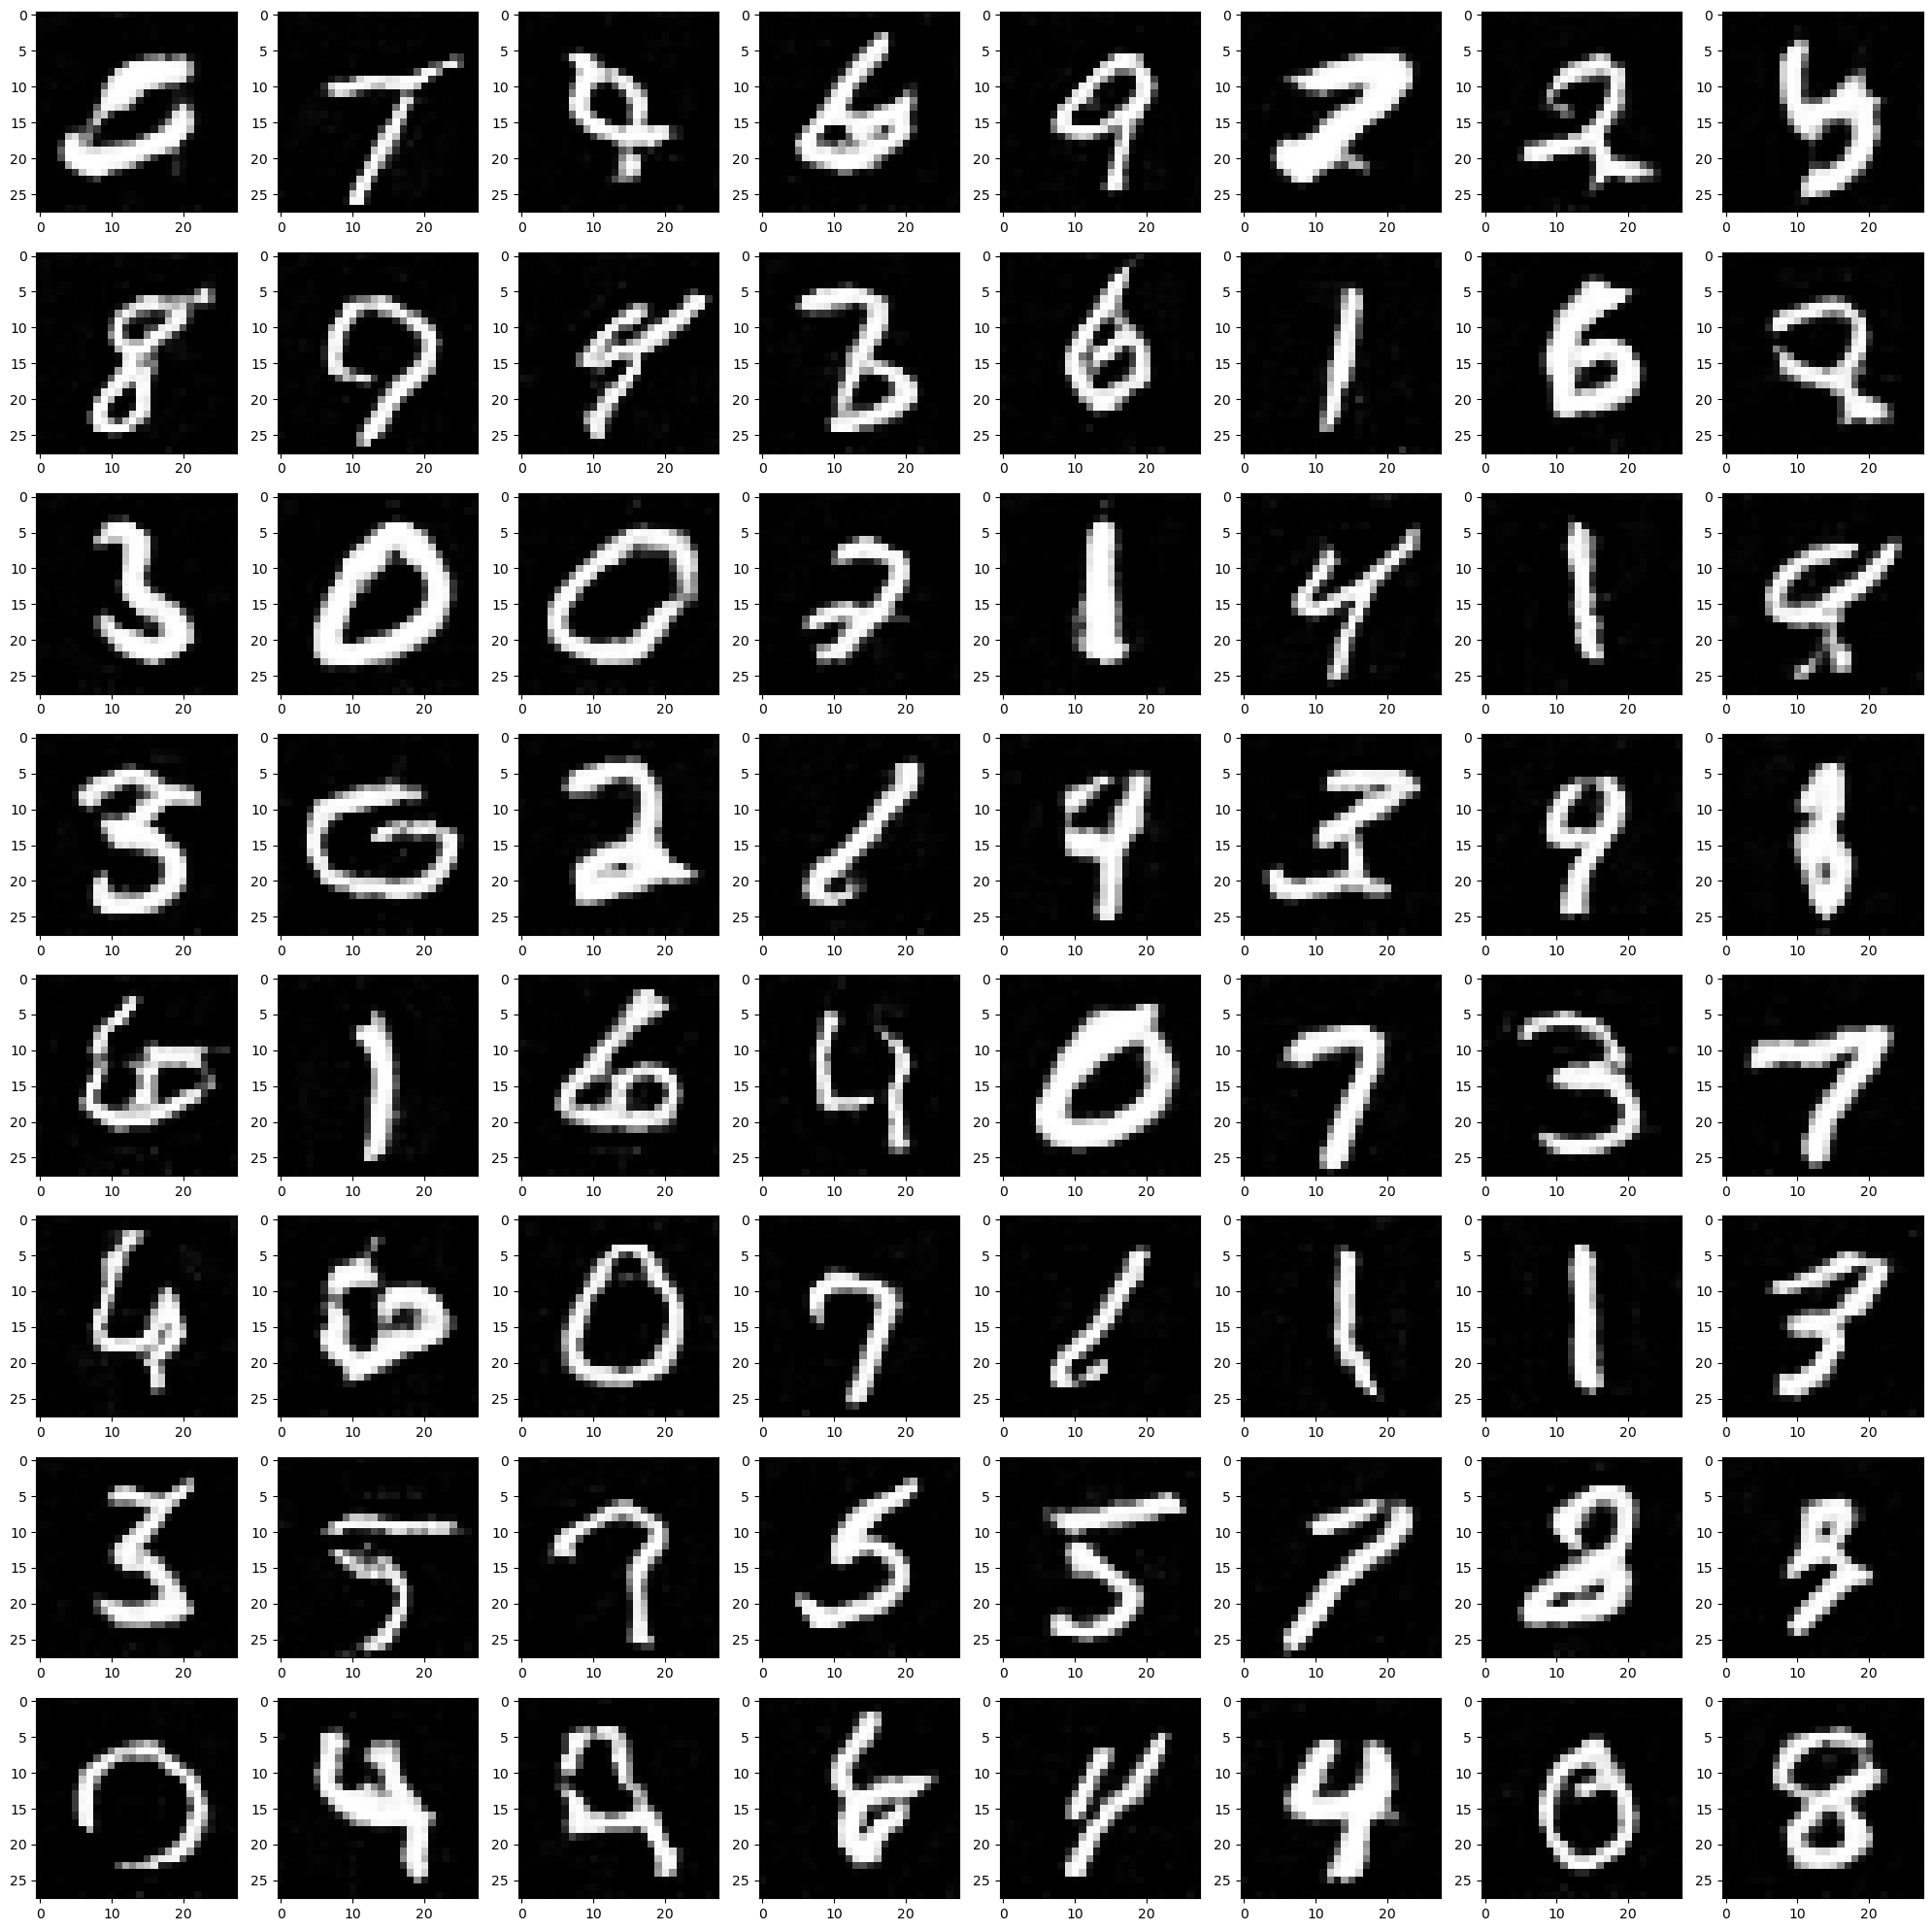

In [12]:
sample = netG(torch.randn(bs, z_dim, 1, 1))

plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample.detach()[i][0], 'gray')

plt.tight_layout()